#Credit Card Fraud Detection CNN
###Author: Aditya Moon
###Description:
#####This project aims to classify transactions as fraudulent/non-fraudulent using a convolutional neural network. The features of this dataset's values are present, but what the features are themselves is unknown, making this task more interesting...
###Primary Objective:
#####Detect as many fraudulent credit card transactions as possible. In terms of a confusion matrix, this obviously involves maximizing true positives. But it also involves minimizing false negatives (the number of fraudulent transactions that get flagged as non-fraudulent), potentially at the cost of having more false positives (recall vs. precision trade-off, in our case we'd prefer having a higher recall at the cost of a lower precision). Why do we prefer this? Imagine you are a banking customer for RaspberryBank. Would you rather have RaspberryBank send you a notification that your card was used for fraud when it was really you (false positive)? Or would you prefer that RaspberryBank **doesn't** send you a notification when your card was actually used for fraud (false negative)? Of course, the former is preferred, hence, why we prefer minimizing false negatives even at the potential expense of having more false positives.

#####Maximizing true positives and minimizing false negatives statistically means that we want to achieve a **high recall score**.
Recall definition: Recall is the percentage of positive instances correctly identified.

---


#####Link to the original dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

#0. Imports and Settings

In [1]:
! pip install psycopg2-binary sqlalchemy pandas numpy matplotlib seaborn pyspark scikit-learn torch kaggle
! mkdir ~/.kaggle
! kaggle datasets download "mlg-ulb/creditcardfraud" --force
! unzip creditcardfraud.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl

In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

df = pd.read_csv("creditcard.csv")
plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)

pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.width", 1000)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(24) #my lucky number

#1. Data Understanding
###Let's get an idea of what we are working with!

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'], dtype='object')

In [7]:
print(df.shape)

(284807, 31)


In [8]:
df[["Time", "Amount", "Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


#2. DataFrame Preprocessing
###Let's clean up the dataframe a little bit for optimal use later.

##2.1 General Preprocessing

####Number of unique values:

In [9]:
print(df.nunique())

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64


#####The number of unique values above seems normal.
#####We have 2 classes in the Class column. Let's take a quick look on how they're represented, as well as their value counts:

In [10]:
df["Class"].value_counts()

,count
Class,
0,284315
1,492


#####We can see that the class labels use typical numerical encoding of
#####0 - Non fraudulent
#####1 - Fraudulent

#####And also, **WOW!** That's a very imbalanced distribution. In our df, we clearly have a lot more rows classified as non-fraudulent than fraudulent. This is a problem. We will talk more about why it's a problem and how to deal with it later. For now, let's continue cleaning up the data.

####See number of values that are "0" in each column
#####0 values sometimes occur in columns as a representation of null values.

In [11]:
(df == 0).sum(axis=0)

,0
Time,2
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


#####Now obviously there are 0 values for the class column, but for the Time and Amount columns they're aren't supposed to be. Since there's a notable amount of 0 values in the Amount column, let's make sure its class label distribution is normal before we remove them (basically a sanity check).

In [12]:
df.loc[df["Amount"] == 0]["Class"].value_counts()

,count
Class,
0,1798
1,27


#####Looks good. Let's remove them:

In [13]:
df = df.query("Amount != 0 and Time != 0")

####Check for null values

In [14]:
print(df.isna().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


####Scaling
#####Something I noticed all the way back when we did df.describe() is that the distribution for Amount/Time is way larger than the distribution for the other columns. Therefore, it's a good idea to scale them. Let's try various scaling methods and pick the one with the most reasonable range (using inspection):

#####Log Scaling

In [15]:
import math
df["Time"].apply(lambda x : math.log(x)).describe()

,Time
count,282980.000000
mean,11.253137
std,0.817473
min,0.000000
25%,10.901409
50%,11.346971
75%,11.844846
max,12.059844


#####Quantile Transformer

In [16]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution="uniform")
time_col = df["Time"].values.reshape(-1, 1)

quantile_time = scaler.fit_transform(time_col)

time_df = pd.DataFrame(quantile_time, columns=["Time"])
time_df.describe()

,Time
count,282980.000000
mean,0.495810
std,0.288890
min,0.000000
25%,0.248433
50%,0.490727
75%,0.745603
max,1.000000


#####Robust Scaler

In [17]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
time_col = df["Time"].values.reshape(-1, 1)

robust_time = scaler.fit_transform(time_col)

time_df = pd.DataFrame(robust_time, columns=["Time"])
time_df.describe()

,Time
count,282980.000000
mean,0.119151
std,0.557879
min,-0.995253
25%,-0.357834
50%,0.000000
75%,0.642166
max,1.034919


#####Standard Scaler

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_col = df["Time"].values.reshape(-1, 1)

standard_time = scaler.fit_transform(time_col)

time_df = pd.DataFrame(standard_time, columns=["Time"])
print(time_df.describe().round(2))

            Time
count  282980.00
mean       -0.00
std         1.00
min        -2.00
25%        -0.85
50%        -0.21
75%         0.94
max         1.64


#####We'll go with the StandardScaler since it seems to keep it's original distribution shape while remaining relatively small like the other column distributions.

In [19]:
df["Time Scaled"] = scaler.fit_transform(time_col)

amount_col = df["Amount"].values.reshape(-1, 1)
df["Amount Scaled"] = scaler.fit_transform(amount_col)


In [20]:
df.drop(columns=["Amount", "Time"], inplace=True)

#####Let's reorder our columns quickly.
#####It's important that we put the class label as our first column so that it's easier for our CNN custom dataset later.

In [21]:
df = df[["Class", "Amount Scaled", "Time Scaled", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"]]

##2.2 Splitting our data
#####It's time to split our data into training and testing splits.
#####Note: we will not be doing cross validation. This is because our dataset is already almost 300k values. Moreover, given that we are using a CNN for this classification task, doing cross validation would be overkill.

In [22]:
from sklearn.model_selection import train_test_split

training_df, test_df = train_test_split(df, test_size=0.15, stratify=df["Class"], random_state=24)

####Parameter explanation

*   Given the high imbalance of our dataset, it is important that we get extra rows of the minority class to train on, so we will go with a 0.85/0.15 split.
*   Enabling Stratify ensures that both the training and testing dataframes get a proportionate amount of the minority class in their split. Stratify will also ensure that both of them are shuffled.
*   Random_state allows for replicable results (my lucky number is 24).




##2.3 Dealing with our class label imbalance

In [23]:
training_df["Class"].value_counts()

,count
Class,
0,240138
1,395


#####Remember the class label imbalance we saw previously? If unaddressed, this issue could cause our CNN to overfit to the imbalance, leading to our CNN predicting the majority class (non-fraudulent) excessively. Given how large the imbalance is, it might even fail to predict the minority class (fraudulent) altogether.

In [24]:
print(f"Currently {100 * training_df['Class'].value_counts()[0]/training_df.shape[0]:.2f}% non-fraud and {100*training_df['Class'].value_counts()[1]/training_df.shape[0]:.2f}% fraud")

Currently 99.84% non-fraud and 0.16% fraud


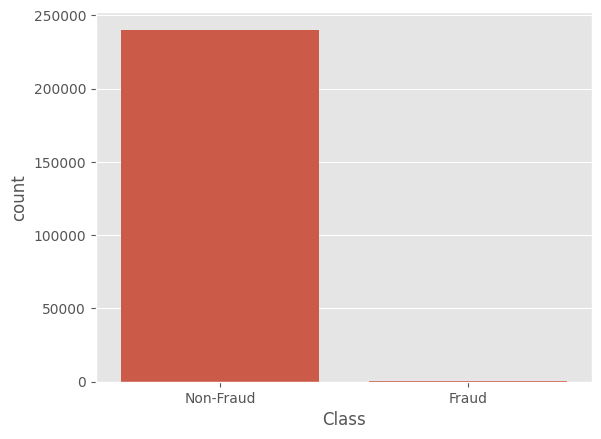

In [25]:
sns.barplot(x="Class", y="count", data=training_df["Class"].value_counts().reset_index())
plt.xticks(ticks=[0, 1], labels=["Non-Fraud", "Fraud"])
plt.show()

#####To deal with the imbalance, there are a few techniques we could use, including undersampling and SMOTE.
#####Both were tested and the best results were ultimately achieved with **undersampling**.
#####Undersampling works by taking the majority class and reducing its' number of rows in the dataframe to that of the minority class, thus giving an even balance to train on. Let's apply it:

In [26]:
one_df = training_df.query("Class == 1")
zero_df = training_df.query("Class == 0").sample(len(one_df))

undersampled_df = pd.concat([zero_df, one_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

#####Now if we look at the class labels balance:

In [27]:
undersampled_df["Class"].value_counts()

,count
Class,
0,395
1,395


#####Perfect.

#####You might have noticed that we only applied our undersampling technique to the training_df. This is because we only need an even distribution between the class labels when we train our model so that our model does not overfit to predicting non-fraud too often.
#####We use the testing_df....for testing. Given that we want to model a real world scenario, and that the class imbalance present in the original dataset also exists in real life (only a small % of transactions in the real world are fraudulent), we therefore, want to keep this imbalance in our testing_df.



###A final note:
#####I did not do any outlier removing because these outliers are crucial in finding fraud transactions.
#####While feature understanding is included in the next section, feature relations were also skipped given that the features themselves are unclear. Moreover, no one feature has a significant correlation with the class labels column (as you're about to see).

#3. Feature Understanding

#####Let's see if there are any *significant* correlations between our columns and our class labels:

In [28]:
df.corrwith(df["Class"])

,0
Class,1.000000
Amount Scaled,0.006533
Time Scaled,-0.013012
V1,-0.100950
V2,0.089696
V3,-0.190200
V4,0.130052
V5,-0.096833
V6,-0.042167
V7,-0.184753


#####Statistically speaking, there are no significant correlations. However, we can still take a look at the distribution of any features with a low correlation with our class labels, which we will define loosely at .25 (or greater/less):

Kurtosis of V12: 1.1891016198318534
Kurtosis of V14: 0.7488989090857641
Kurtosis of V17: 0.26330675247853597


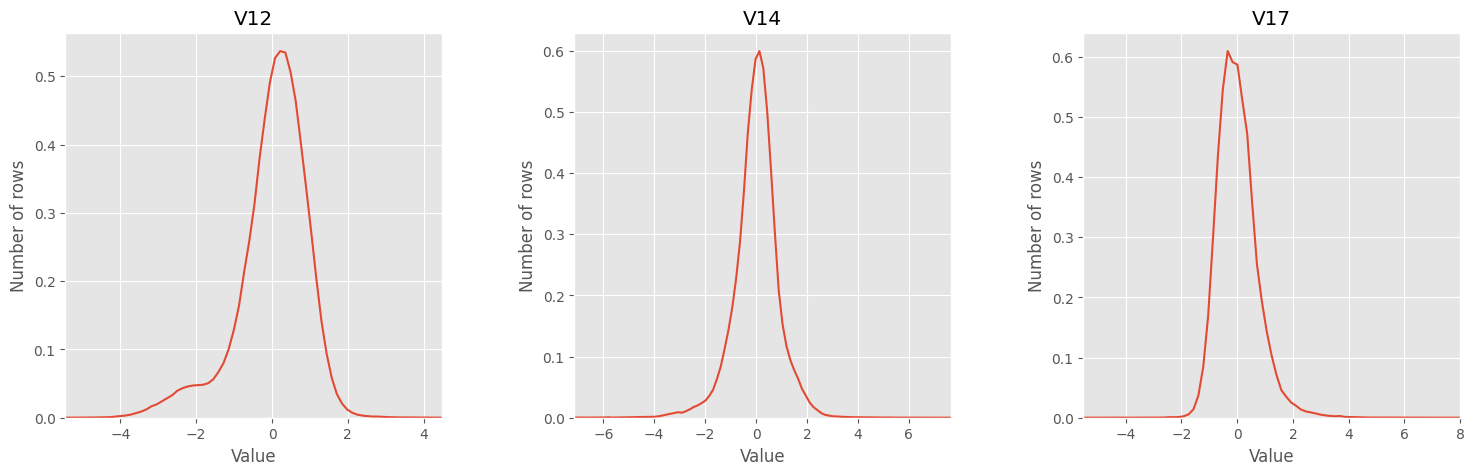

In [29]:
from scipy.stats import kurtosis

figure, axis = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"wspace": 0.35})
axes = axis.flatten()

columns = ["V12", "V14", "V17"]

for i, col in enumerate(columns):
  sns.kdeplot(df[col], ax=axes[i])
  axes[i].set_title(col)
  axes[i].set_xlabel("Value")
  axes[i].set_ylabel("Number of rows")
  axes[i].set_xlim(df[col].quantile(0.001), df[col].quantile(0.99999))
  print("Kurtosis of", col + ":", kurtosis(df[col][(df[col] > df[col].quantile(0.01)) & (df[col] < df[col].quantile(0.99))])) #We are using Fisher's definition
plt.show()

#####The only important information we can derive from these graphs is that our categories with a low negative correlation with our class labels have a relatively even distribution.

#4. CNN Classification Model
###Let's begin the fun part!

##4.1 Setting up to begin our CNN training
#####Before we train our CNN model we need to do a few steps.


####Dataset/Dataloaders
#####Remember that we are working with the 1. undersampled_df for training and 2. test_df for testing. We need to create custom datasets that make it easier to work with these dfs. We then need to use these custom datasets and pass them into dataloaders. Dataloaders enable our data to be trained in batches. Regarding batch size, the higher the batch size the lower the computational power required, but the higher chance that we miss out on capturing patterns in our features. I went with a default batch size of 32. In addition, dataloaders also allow each batch to be shuffled.


In [30]:
class CardDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        class_value = torch.tensor(row[0]).long()  #This is why we want our target variable in the first column
        features = torch.tensor(row[1:].values, dtype=torch.float32)  #Features in the remaining columns
        return features, class_value, index

#Create dataset and dataloader
training_dataset = CardDataset(dataframe=undersampled_df)
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

test_dataset = CardDataset(dataframe=test_df)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

####Coding our CNN

In [31]:
class CreditCardFraudCNN(nn.Module):
    def __init__(self, number_of_features):
        super().__init__()
        self.convolution_layer_1 = nn.Conv1d(in_channels=1, out_channels=8, padding=1, kernel_size=3) #Padding of 1 in conv layers makes it so the data size is the same after passing through
        self.convolution_layer_2 = nn.Conv1d(in_channels=8, out_channels=16, padding=1, kernel_size=3) #A kernel size of 3x3 on the filter is standard
        self.pool_layer = nn.MaxPool1d(kernel_size=2, padding=0, stride=2) #Standard pooling layer

        input_size_for_linear = 16 * (number_of_features//4) #See below. The number of features is divided by 4 because the pooling layer is applied twice in the forward pass. Given a kernel of 2 and stride of 2, the pooling layer essentially
        #goes through every 2 cells and picks the best one, choosing 1 cell out of 2. So each time we go through the pooling layer the data is halved. Doing it twice, the number of features is ultimately divided by 4.

        self.linear_layer_1 = nn.Linear(input_size_for_linear, 128)
        self.linear_layer_2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.unsqueeze(x, 1) #We need to add an extra layer to our features before they are passed into the conv layer
        x = self.pool_layer(torch.relu(self.convolution_layer_1(x))) #Apply relu to remove negative values and for better results
        x = self.pool_layer(torch.relu(self.convolution_layer_2(x)))
        x = torch.flatten(x, 1) #We no longer need the extra layer

        x = torch.relu(self.linear_layer_1(x)) #Apply ReLU again
        x = self.linear_layer_2(x) #Removing ReLU here gives better results
        return x

undersampled_df_length = len(undersampled_df.columns) - 1 #Exclude class labels so len - 1
net = CreditCardFraudCNN(undersampled_df_length)

####CNN Choices:
#####All parameters above were optimized after lots of trial and error.
#####Two convolutional layers were chosen with a pooling layer. The conv layers are 1d, given that our data is just tabular.
#####Two linear layers were used.


####Choosing an optimizer and a loss function


In [32]:
class_weights = torch.tensor([3.5, 1.0])
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss(weight=class_weights)

#####The weights on the loss_function were customized to 3.5, 1.0. This means that the CNN will apply a penalty 3.5x harder when the model misclassifies a 1 (fraud) as being a 0 (non-fraud). This is because a primary objective of this model is to prevent false negatives, as explained at the start of the notebook.

##4.2 Training our model
#####We have all the steps we need to train our model, so let's do just that:

In [33]:
epochs = 20

for epoch in range(epochs):
    current_loss_value = 0.0

    for i, data in enumerate(training_dataloader, 0):
        features, class_labels, _ = data

        optimizer.zero_grad() #makes it run faster
        model_train_predictions = net(features)
        loss = loss_function(model_train_predictions, class_labels)

        loss.backward()
        optimizer.step()

        current_loss_value += loss.item()

    print("Epoch", epoch, "| Loss value:", current_loss_value)

<ipython-input-30-aff872c7452b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_value = torch.tensor(row[0]).long()  #This is why we want our target variable in the first column


Epoch 0 | Loss value: 17.102287709712982
Epoch 1 | Loss value: 14.035386204719543
Epoch 2 | Loss value: 11.43876576423645
Epoch 3 | Loss value: 9.359177261590958
Epoch 4 | Loss value: 7.611811995506287
Epoch 5 | Loss value: 6.461604714393616
Epoch 6 | Loss value: 5.659483298659325
Epoch 7 | Loss value: 5.0981917679309845
Epoch 8 | Loss value: 4.796925216913223
Epoch 9 | Loss value: 4.5399623438715935
Epoch 10 | Loss value: 4.33661226183176
Epoch 11 | Loss value: 4.247429206967354
Epoch 12 | Loss value: 4.084699288010597
Epoch 13 | Loss value: 3.9728573337197304
Epoch 14 | Loss value: 3.862715169787407
Epoch 15 | Loss value: 3.797246214002371
Epoch 16 | Loss value: 3.8005444668233395
Epoch 17 | Loss value: 3.782199438661337
Epoch 18 | Loss value: 3.690689004957676
Epoch 19 | Loss value: 3.64995351806283


#####Training just used standard CNN training procedure.
#####I found the model had best results training over 20 epochs.


#####Now that we've trained our model, let's test whether it works!

##4.3 Testing + Results

###4.3.1 Testing

In [34]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0 #The worst

predictions = []
indexes = []

with torch.no_grad(): #Once again for speedup
    for data in test_dataloader:
        features, class_labels, index = data
        model_test_predictions = net(features)
        _, test_prediction_labels = torch.max(model_test_predictions, 1) #Just get the result of the maximum value from each

        true_positive += ((test_prediction_labels == 1) & (class_labels == 1)).sum().item()
        true_negative += ((test_prediction_labels == 0) & (class_labels == 0)).sum().item()
        false_negative += ((test_prediction_labels == 0) & (class_labels == 1)).sum().item()
        false_positive += ((test_prediction_labels == 1) & (class_labels == 0)).sum().item()

        #add the predictions and the indexes
        indexes.extend(index.tolist())
        predictions.extend(test_prediction_labels.tolist())

#Finally, we add every the prediction of every index in predictions/indexes to the testing_df in a new column

test_df.insert(0, "Predicted Class", 0)
for i in range(len(predictions)):
  test_df.iloc[indexes[i], 0] = predictions[i]

test_df = test_df[["Predicted Class", "Class", "Amount Scaled", "Time Scaled", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"]]


<ipython-input-30-aff872c7452b>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_value = torch.tensor(row[0]).long()  #This is why we want our target variable in the first column


We...

*   Applied the CNN to the test_df.
*   Counted the number of true positives, false positives, true negatives, and false negatives.
*   Added our predictions to a new column in our test dataframe. Let's see that below:

In [35]:
test_df

,Predicted Class,Class,Amount Scaled,Time Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
13871,0,0,-0.294706,-1.478915,-1.345153,0.001335,2.811254,-0.761701,0.026696,-0.066165,-0.029167,-0.067116,2.114032,-1.101602,0.320421,-2.681890,0.967194,0.692011,-0.637991,-0.064011,0.619916,-0.446780,-0.799418,-0.204944,-0.249620,-0.198664,-0.083343,0.077386,0.009455,0.849592,-0.459928,-0.096494
162806,0,0,-0.294187,0.432531,1.900061,0.389143,-1.339856,3.637153,0.740999,0.170255,0.247572,0.105516,-1.018452,1.745975,-0.014082,-1.083081,-2.924572,1.149132,-1.446864,0.660033,-0.651284,0.313332,-1.261439,-0.432927,0.292050,0.737103,-0.012706,0.651982,0.303240,0.251442,-0.087612,-0.071719
53644,0,0,2.232118,-1.027058,0.058473,-3.172833,0.056879,-1.526842,-1.986415,0.523719,-0.323160,0.061639,0.692010,-0.686550,0.899298,1.791522,1.040328,-0.397442,-0.284255,-2.335874,0.440341,1.211795,0.220343,0.842306,-0.095274,-0.860401,-0.515467,-0.231847,0.038395,-0.139086,-0.027290,0.125233
52154,0,0,-0.290878,-1.043569,-0.559218,0.831137,2.200541,0.961712,-0.777673,-0.032790,-0.013474,0.150251,-0.114770,0.087420,-0.080991,-0.928189,-1.555775,0.387904,2.483466,-0.499870,0.577585,-0.112558,1.033820,-0.004187,0.060836,0.091310,0.030439,0.377016,-0.635555,0.434908,-0.131202,0.105883
29314,0,0,-0.350841,-1.251733,-0.634639,0.775521,1.728206,-1.391975,-0.144804,-0.740882,0.529490,0.093510,-0.285506,-0.561915,1.222256,0.674518,-0.030743,0.133092,-0.200318,0.793464,-0.928952,0.139700,-0.396182,0.038550,-0.032567,-0.068968,-0.094961,0.365092,-0.372643,0.701573,0.256163,0.163883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44530,0,0,0.292477,-1.113386,0.801798,-0.386188,0.668860,1.252723,-0.674806,-0.030171,-0.131538,0.203593,0.025712,0.108457,1.536118,0.412438,-1.309323,0.753530,0.827051,0.341183,-0.383562,-0.031312,-0.609441,0.077260,-0.019526,-0.489765,0.034173,0.145801,0.060479,-0.619874,0.010446,0.047836
83549,0,0,-0.061914,-0.735810,0.997685,-1.104295,1.665233,1.007489,-1.596507,1.304956,-1.436864,0.544889,0.305480,0.517911,0.247137,1.282420,-0.008543,-0.950288,-2.252489,-2.169438,0.630633,1.065343,-0.611992,-0.466637,-0.376937,-0.264589,-0.027246,0.024319,0.311113,-0.271779,0.129732,0.039965
218552,0,0,1.036303,0.979539,1.677616,-2.250881,-1.596602,-1.280462,-1.442499,-1.149019,-0.322715,-0.507776,-1.621450,1.514427,-0.763805,-0.759704,0.792715,-0.118725,0.271335,-0.612774,0.440331,0.033122,-0.541907,0.251275,0.296533,0.610136,-0.222199,0.029419,-0.050859,0.043675,-0.068126,-0.001449
113883,0,0,-0.336608,-0.454966,-0.375661,1.065411,1.290334,0.077485,0.048860,-1.016924,0.670771,-0.058097,-0.360831,-0.502470,-0.246370,-0.184802,-0.085733,-0.386265,0.918106,0.391099,0.021179,-0.111854,-0.089855,0.115476,-0.261546,-0.708766,-0.000438,0.328315,-0.165076,0.072514,0.242205,0.098875


In [36]:
test_df["Predicted Class"].value_counts()

,count
Predicted Class,
0,42300
1,147


###4.3.2 Results

####Classification Metrics
At the beginning of the notebook, we specified that our **recall** is by far the most important classification metric, and that having a high recall was the primary objective of our model. Let's see what result we got:

In [37]:
recall = true_positive/(true_positive+false_negative)
print(f"Recall: {recall}")

Recall: 0.9


#####**Great!**
#####Remember that recall is the amount of the minority class that our model is able to successfully predict. **Our model is able successfully detect 90% of fraudulent credit card transactions!**

#####Let's have a quick look at the other statistics:

In [38]:
accuracy = (true_positive+true_negative)/(len(test_df))
precision = true_positive/(true_positive+false_positive)
f1_score = 2 *((precision*recall)/(precision+recall))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9978561500223808
Precision: 0.42857142857142855
F1 Score: 0.5806451612903225


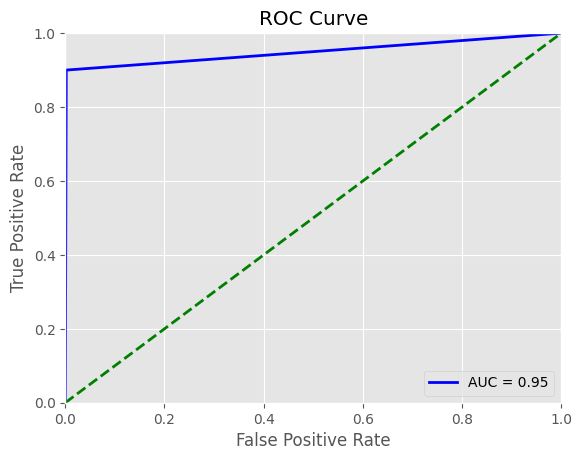

In [39]:
from sklearn.metrics import roc_curve, auc, log_loss

fpr, tpr, _ = roc_curve(test_df["Class"], test_df["Predicted Class"])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, color="blue", label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, color="green", linestyle="dashed")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()


#####Our accuracy and AUC scores are fantastic!
#####Our precision and F1 score aren't as good as our recall. They also aren't bad. And they also aren't as important. The important thing is that our recall is great. As long as the number of false positives isn't too high and the ratio between false positives/true positives is realistic for a bank, our model works great. Let's confirm that this is the case in a confusion matrix:

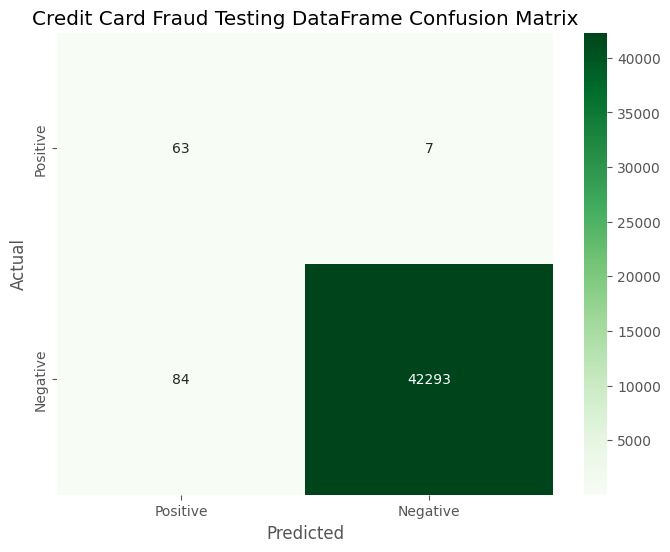

In [40]:
confusion_matrix = np.array([
    [true_positive, false_negative],
    [false_positive, true_negative]
])

confusion_matrix_plot = plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"], annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Credit Card Fraud Testing DataFrame Confusion Matrix")
plt.show()

#Looks great! 🎆

##### Final sanity check to ensure that the results above add up to their expected values
#####The top row should be in the CM (confusion matrix) should add up to the number of fraud values above (and the bottom row of the CM should add up to the number of non-fraud values above)

In [41]:
test_df["Class"].value_counts()

,count
Class,
0,42377
1,70


#5. Conclusion: A Little Bit of Bragging

#####We successfully detected 90% of fraudulent credit card transactions, achieving an AUC of 0.95. We also had an accuracy of over 99%.
#####The ratio between true positive and false positive transactions is 3:4 (as a banking customer, for every 3 true fraudulent purchases on your card, there are 4 everyday purchases that accidentally get flagged as fraudulent). This might sound like a lot. However, if you've ever been with a Canadian bank, you'll know they love blasting you with notifications about how your everyday purchases could be fraudulent. In this aspect, this CNN performs much better.



---



#Thanks for checking out my project. I appreciate your time 🙂